# СОДЕРЖАНИЕ РАБОТЫ
0. Постановка задачи
1. Загрузка данных и разведывательный анализ
2. OneHotEncoding
3. Обработка пропусков
4. Обучающий и тестовый наборы
5. Простая логистическая регрессия
6. Случайный лес с параметрами по умолчанию
7. Случайный лес на стандартизированных данных
8. Решётчатый поиск по сетке параметров случайного леса
9. XGBoost
10. LightGBM
11. Ресэмплинг со SMOTHE
12. Интерпритация модели
13. Заключение и подготовка модели к деплою

# 0. Постановка задачи
Задача заключается в прогнозировании кредитоспособности клиентов American Express. Поскольку данные, которые взяты с Kaggle, слишком большие, уменьшим выборку до 30 тысяч строк. Сначала загрузим необработанные данные и выполним предварительный анализ (EDA), чтобы понять особенности датасета. 

Данные для работы взяты с публичной веб-платформы https://www.kaggle.com/competitions/amex-default-prediction/overview, соревнование American Express - Default Prediction.

# 1. Загрузка данных и разведывательный анализ

## 1.1 Описание данных

Необходимо предсказать вероятность того, что клиент не вернёт сумму кредита в будущем, основываясь на его ежемесячном профайлинге. Целевая бинарная переменная основана на 18-тимесячных наблюдениях за периодом исполнения по кредиту, и если клиент не выплачивает причитающуюся сумму в течение 120 дней после даты последней выписки, то его следует считать банкротом.

Взглянем на краткое описание датасета. Данные содержат агрегированные характеристики каждого клиента по состоянию на дату выписки. Признаки анонимизированы и нормализованы, подразделены на следующие категории:
* D_*: переменные, связанные с нарушениями кредитных условий
* S_*: переменные, связанные с тратами
* P_*: переменные, связанные с платежами
* B_*: перемнные, связанные с балансом
* R_*: переменные, связанные с рисками.

Следующие признаки являются **категориальными**:  
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

***target = 1*** - банкротство.

## 1.2 Чтение данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("data/train_data.csv", nrows=30000)
train_labels = pd.read_csv("data/train_labels.csv")
data = pd.merge(train_data, train_labels, how="inner", left_on=["customer_ID"], right_on=["customer_ID"])

In [3]:
del train_data
del train_labels

In [4]:
data.head(7)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0.001746,0.007863,1.005006,0.004220,0.110946,0.009857,0.009866,...,NaN,NaN,0.001924,0.008598,0.004529,NaN,0.000674,0.002223,0.002884,0
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0.002183,0.018859,1.008024,0.004509,0.103329,0.006603,0.000783,...,NaN,NaN,0.001336,0.004361,0.009387,NaN,0.007727,0.007661,0.002225,0


## 1.3 Краткое описание данных

In [5]:
data.shape

(30000, 191)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
P_2,29731.0,0.655988,0.247479,-2.850139e-01,0.473929,0.698992,0.867069,1.009949
D_39,30000.0,0.151907,0.266710,8.701630e-07,0.004563,0.009131,0.214314,5.009303
B_1,30000.0,0.130432,0.220981,-1.414690e-01,0.008878,0.032494,0.133614,1.323981
B_2,29995.0,0.611011,0.404271,3.308280e-06,0.091592,0.813886,1.002137,1.010000
R_1,30000.0,0.079535,0.224062,3.154721e-07,0.002886,0.005777,0.008671,2.504515
...,...,...,...,...,...,...,...,...
D_142,5128.0,0.386648,0.248392,-1.394664e-02,0.180099,0.373416,0.562123,1.486382
D_143,29490.0,0.178313,0.378551,2.360950e-07,0.003009,0.006044,0.009056,1.010000
D_144,29790.0,0.053892,0.186551,5.802874e-07,0.002745,0.005470,0.008255,1.343284
D_145,29490.0,0.057071,0.193579,1.577788e-07,0.003032,0.006035,0.009073,4.282032


Данные неплохо отмасштабированы. Немного значений имеют **max > 1**, но это можно объяснить тем, что класс **MinMaxScaler** (как и все остальные типы классов масшибирования) всегда применяет одинаковое преобразование к обучающему и тестовому наборам. Это означает, что метод **transform** всегда вычитает минимальное значение, вычисленное для обучающего набора, и делит на ширину диапазона, вычисленную также для обучающего набора. Тогда как в действительности минимальное значение и ширина диапазона для обучающего набора могут отличаться от миннимального значения и ширины диапазона для тестовго набора.

## 1.4 Разведывательный анализ (EDA)

Посмотрим на распределение целевой переменной **'target'**. 

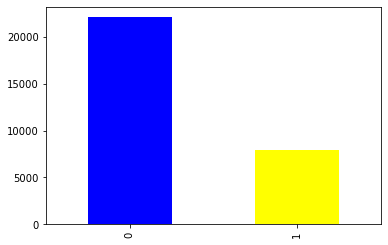

In [7]:
data["target"].value_counts().plot.bar(color=['blue', 'yellow']);

Выборка не сбалансирована.

Проверим данные на пропуски.

In [8]:
data.isnull().sum().sort_values(ascending=True) / data.shape[0]*100

customer_ID     0.000000
R_14            0.000000
R_13            0.000000
B_28            0.000000
R_12            0.000000
                 ...    
B_39           99.483333
D_110          99.510000
D_111          99.510000
D_88           99.863333
D_87           99.883333
Length: 191, dtype: float64

Много признаков имеют более 75% пропусков, следовательно, они не представляют никакой статистической значимости. Удалим их.  
Так же удалим столбец **S_2** с датой.  

In [9]:
data.drop(['S_2'], axis=1, inplace=True)

In [10]:
thresh = data.isnull().mean() > 0.75
data.drop(data.columns[thresh], axis=1, inplace=True)

In [11]:
data.shape

(30000, 167)

В итоге убрали 24 признака.

Посмотрим, какие признаки целочисленные, а какие - с плавающей точкой.

In [12]:
int_cols = data.dtypes == int
int_cols = data.columns[int_cols]
int_cols

Index(['B_31', 'target'], dtype='object')

Всего два признака целочисленные - **B_31** и **target**.

In [13]:
float_cols = data.dtypes == float
float_cols = data.columns[float_cols]
float_cols

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43',
       'D_44',
       ...
       'D_130', 'D_131', 'D_133', 'R_28', 'D_139', 'D_140', 'D_141', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=162)

Признаков с пдавающей точкой 162.

### Корреляция с целевой переменной

In [14]:
corrs  = data[float_cols].corrwith(data["target"]).abs()
corrs.sort_values(inplace=True, ascending=False)
corrs[:10] # Так как признаков более 160, то выведем первые 10

P_2     0.624216
D_48    0.575019
D_61    0.522770
B_18    0.498167
B_9     0.490050
B_2     0.485957
D_44    0.479014
D_75    0.478562
D_55    0.478047
D_58    0.465128
dtype: float64

Признаков с сильной корреляцией >0.7 нет, что хорошо.

In [15]:
corrs_cols = list(corrs[:10].index)
corrs_cols.append('target')
print(corrs_cols)

['P_2', 'D_48', 'D_61', 'B_18', 'B_9', 'B_2', 'D_44', 'D_75', 'D_55', 'D_58', 'target']


Построим матрицу диаграмм рассеяния, показывающий отношения между различными переменными в наборе данных. 
До диагонали должны быть распределения велечин, во всех остальных ячейках отображаются диаграммы рассеяния отношений между каждой парной комбинацией переменных.

In [16]:
#ax = sns.pairplot(data[corrs_cols], hue='target');
#sns.set(rc={'figure.figsize':(11.7,8.27)})

Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

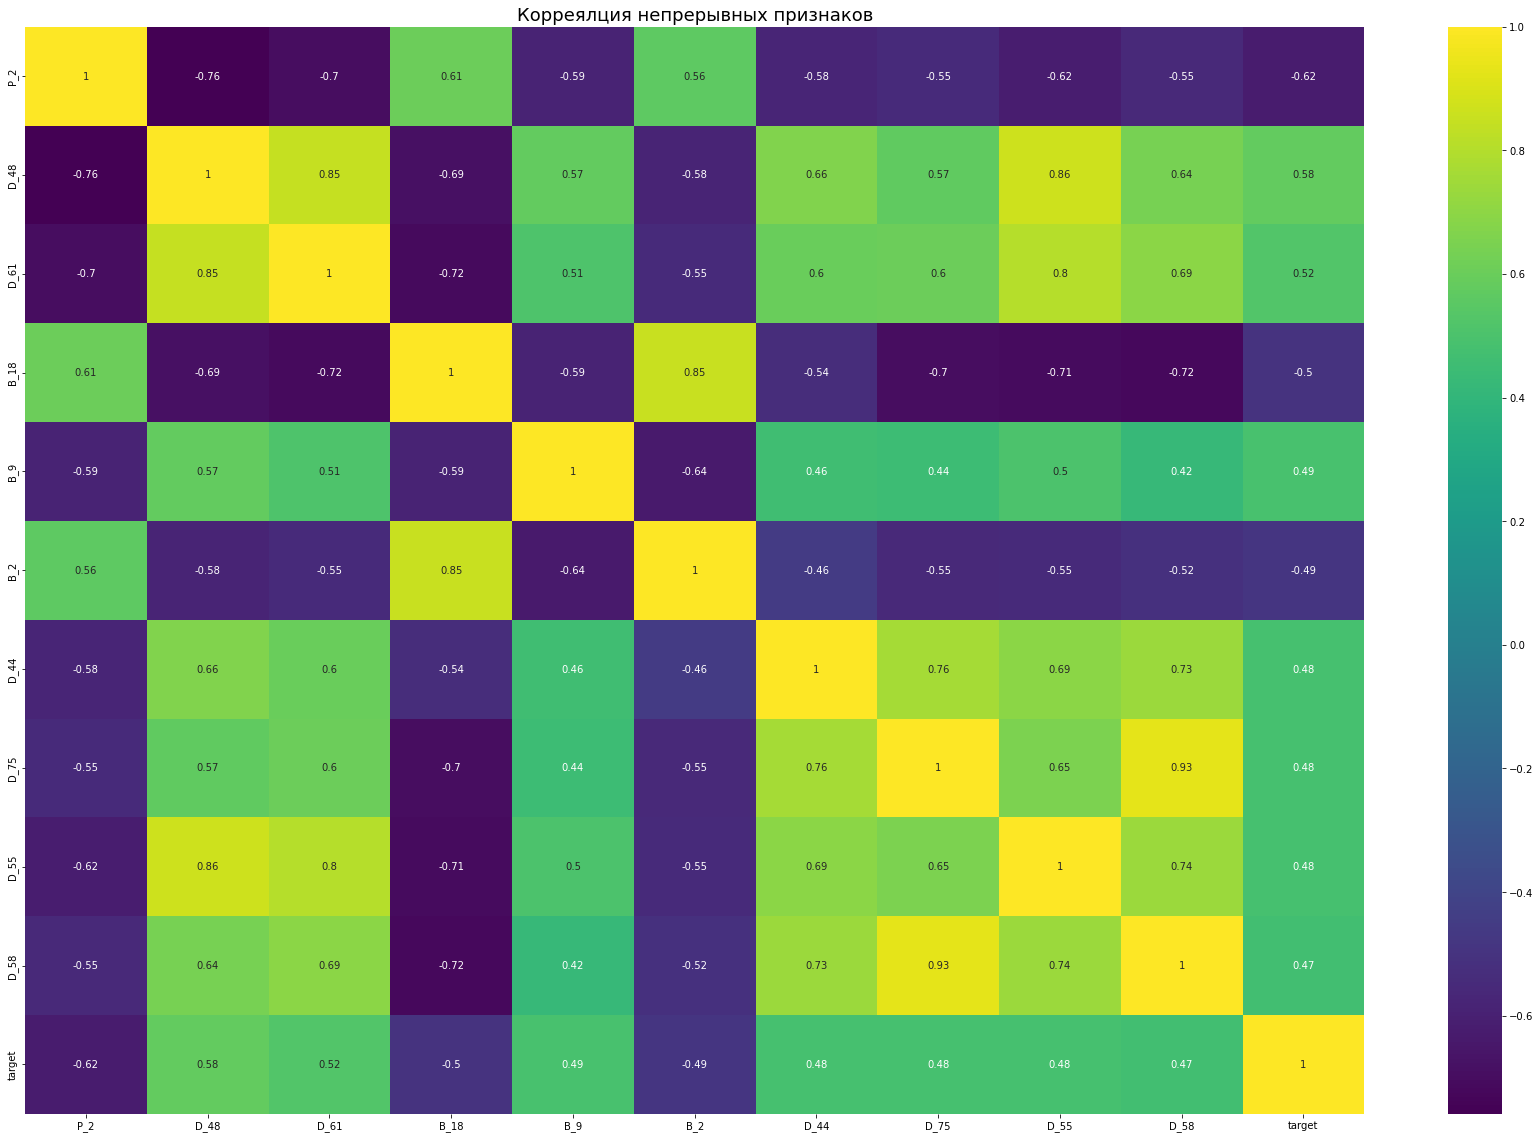

In [17]:
fig,ax = plt.subplots(figsize=(30,20))
corr = data[corrs_cols].corr(method="pearson")
sns.heatmap(corr,
            annot=True,
            ax=ax,
            cmap="viridis",
            fmt=".2g")
ax.set_title("Корреялция непрерывных признаков", fontsize=18)
plt.show()

Для категориальных признаков необходимо выполнить OneHot-кодирование, а затем рассмотреть различные алгоритмы классификации.

# 2. OneHotEncoding

In [18]:
mask = data.dtypes == object
mask["customer_ID"] = False # Не кодируем
categorical = data.columns[mask]
print(categorical)

Index(['D_63', 'D_64'], dtype='object')


Посмотрим, сколько столбцов добавится после кодирования. 

In [19]:
num_of_ohe_cols = (data[categorical].apply(lambda x: x.nunique()).sort_values(ascending=False))
num_of_ohe_cols = num_of_ohe_cols.loc[num_of_ohe_cols > 1] # Не кодируем, если только одно значение в признаке
num_of_ohe_cols -= 1 # Признаков должно быть на единицу меньше, чем категорий
num_of_ohe_cols.sum() 

8

При кодировании получится 10 признаков, но два уже было.

In [20]:
data[categorical[0]].value_counts()

CO    22441
CR     4752
CL     2566
XZ      150
XL       49
XM       42
Name: D_63, dtype: int64

In [21]:
data[categorical[1]].value_counts()

O     16358
U      8175
R      4207
-1      200
Name: D_64, dtype: int64

In [22]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [23]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder()

for col in num_of_ohe_cols.index: 
    
    data_to_encode = label_encoder.fit_transform(data[col]).astype(int) # Целочисленное кодирование
    new_data = ohe.fit_transform(data_to_encode.reshape(-1, 1)) # Разреженный массив
    
    # Подпишем новые столбцы:
    n_cols = new_data.shape[1]
    col_names = ["_categ_".join([col, str(x)]) for x in range(n_cols)]
    
    # Новые кодированные данные:
    new_dataframe = pd.DataFrame(new_data.toarray(), 
                                 index=data.index,
                                 columns=col_names)
    
    # Добавим кодированные данные к имеющемуся датасету
    data = pd.concat([data, new_dataframe], axis=1)
    
    # Удалим изначальные признаки, которые закодировали
    data = data.drop(col, axis=1)

In [24]:
data.head()

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,...,D_63_categ_1,D_63_categ_2,D_63_categ_3,D_63_categ_4,D_63_categ_5,D_64_categ_0,D_64_categ_1,D_64_categ_2,D_64_categ_3,D_64_categ_4
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Категориальные признаки закодированы.

# 3. Обработка пропусков

Для распределений, похожих на логнормальные, где пик близок к 0, высока вероятность наличия выбросов. Математически доказано, что среднее очень чувствительно к выбросам, а вот медианное значение - нет, поэтому будем использовать медиану для заполнения пропусков.

In [25]:
for col in data.columns:
    if col in int_cols or col in float_cols:
        fill_value = data[col].median()
        data[col].fillna(value=fill_value, inplace=True)

In [26]:
data.isnull().sum().sum()

0

# 4. Обучающий и тестовый наборы

In [27]:
X = data.drop(["customer_ID", "target"], axis=1)
y = data["target"]

In [28]:
from sklearn.model_selection import train_test_split, StratifiedKFold

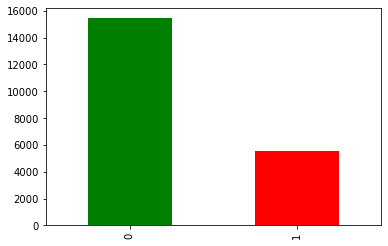

In [29]:
# Hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

y_train.value_counts().plot.bar(color=["green", "red"]);

In [30]:
# Кросс-валидация
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    
    X_train_cv, y_train_cv = X.loc[train_index], y.loc[train_index]
    X_test_cv, y_test_cv = X.loc[test_index], y.loc[test_index]

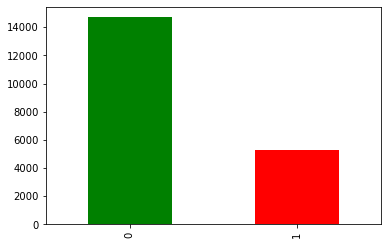

In [31]:
y_train_cv.value_counts().plot.bar(color=["green", "red"]);

Стратифицированное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.  

Подходы Hold-out и StratifiedKFold дают одинаковую пропорцию классов, примерно 3:1. Hold-out под обучающую выборку выделила 21000 наблюдений, а StratifiedKFold - 20000 наблюдений. Так как соотношение одинаковое, будем использовать обучающую и тестовую выборки Hold-out. 

# 5. Простая логистическая регрессия

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, \
    plot_confusion_matrix, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay


Первая модель будет логистическая регрессия. Рассчитаем метрики.

In [33]:
log_reg_model = LogisticRegression(
    penalty="l2",
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

In [34]:
# Обучаем модель
log_reg_model.fit(X_train, y_train) 

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [35]:
#Делаем предсказания
y_test_log_reg_model_pred = log_reg_model.predict(X_test)

Напишем функцию, которая выводила бы метрики с их значениями.

In [36]:
def evaluate_model(y_test, y_pred, model=None):
    """_summary_

    Args:
        y_test (_type_): pandas.core.series.Series
        y_pred (_type_): pandas.core.series.Series
        model (_type_, optional): str. Defaults to None.
    """
    results = {}
    results["model to evaluate"] = model
    results["accuracy"] = round(accuracy_score(y_test, y_pred), 3)
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, beta=10, pos_label=1, average="binary")
    results["recall"] = round(recall, 3)
    results["precision"] = round(precision, 3)
    results["f_score"] = round(f_score, 3)
    results["auc"] = round(roc_auc_score(y_test, y_pred), 3)
    
    return results

In [37]:
metrics = []
metrics.append(evaluate_model(y_test, y_test_log_reg_model_pred, "LogisticRegression"))
display(metrics)

[{'model to evaluate': 'LogisticRegression',
  'accuracy': 0.882,
  'recall': 0.747,
  'precision': 0.796,
  'f_score': 0.747,
  'auc': 0.839}]

Выведем матрицу ошибок.

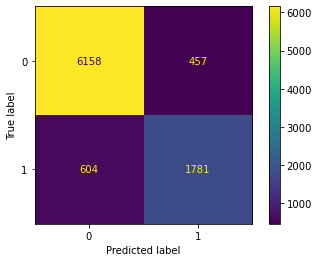

In [38]:
fig = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_test_log_reg_model_pred),
    display_labels=log_reg_model.classes_)
fig.plot();

# 6. Случайный лес с параметрами по умолчанию

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rf_defaults = RandomForestClassifier(random_state=42)
rf_defaults.fit(X_train, y_train)
y_test_rf_defaults_pred = rf_defaults.predict(X_test)

In [41]:
metrics.append(evaluate_model(y_test, y_test_rf_defaults_pred, "RFC with default params"))
display(metrics[1])

{'model to evaluate': 'RFC with default params',
 'accuracy': 0.941,
 'recall': 0.871,
 'precision': 0.902,
 'f_score': 0.872,
 'auc': 0.919}

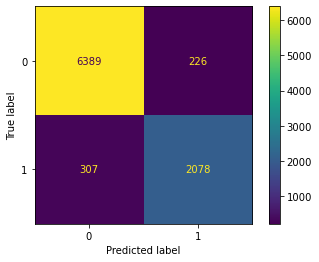

In [42]:
fig = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_test_rf_defaults_pred),
    display_labels=rf_defaults.classes_)
fig.plot();

Вывод: модель случайного леса с параметрами по умолчанию справилась с поставленной задачей лучше, чем логистическая регрессия.

# 7. Случайный лес на стандартизированных данных

Будем использовать конвейер для обучения RandomForestClassifier-модели после стандартизации данных с помощью класса StandartScaler.
 
Когда используется конвейер, отбор признаков осуществляется внутри цикла перекрёстной проверки. Это означает, что для отбора признаков могут использоваться только обучающие блоки, а не тестовый блок.

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [44]:
pipeline = Pipeline([("Scaler", StandardScaler()), ("rfc", RandomForestClassifier(random_state=42))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('rfc', RandomForestClassifier(random_state=42))])

In [45]:
y_test_rf_standard_pred = pipeline.predict(X_test)

In [46]:
metrics.append(evaluate_model(y_test, y_test_rf_standard_pred, "RFC with standard data"))
display(metrics[2])

{'model to evaluate': 'RFC with standard data',
 'accuracy': 0.941,
 'recall': 0.871,
 'precision': 0.905,
 'f_score': 0.871,
 'auc': 0.919}

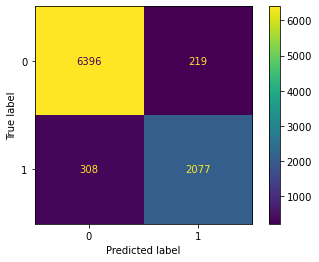

In [47]:
fig = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_test_rf_standard_pred),
    display_labels=pipeline.classes_)
fig.plot();

Вывод: модель не улучшилась после стандартизации.

# 8. Решётчатый поиск по сетке параметров случайного леса

Использование конвейера в объекте GridSearchCV аналогично использованию любой другой модели. Мы задаём сетку параметров для поиска и строим объект класса GridSearchCV на основе конвейера и сетки параметров.

Зададим сетку парметров.

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }

In [50]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8},
                                          {0: 0.3, 1: 0.7}],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [25, 50, 100]})

In [51]:
grid_search.best_params_

{'class_weight': {0: 0.3, 1: 0.7},
 'max_depth': 20,
 'min_samples_split': 2,
 'n_estimators': 100}

In [52]:
rfc_grid = RandomForestClassifier(
    class_weight={0: 0.3, 1: 0.7}, 
    max_depth=20,
    min_samples_split=5, 
    n_estimators=100,
    random_state=42
)

In [53]:
rfc_grid.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=20,
                       min_samples_split=5, random_state=42)

In [54]:
y_test_rf_grid_pred = rfc_grid.predict(X_test)

In [55]:
metrics.append(evaluate_model(y_test, y_test_rf_grid_pred, "RFC by GridSearchCV"))
display(metrics[3])

{'model to evaluate': 'RFC by GridSearchCV',
 'accuracy': 0.931,
 'recall': 0.859,
 'precision': 0.876,
 'f_score': 0.859,
 'auc': 0.908}

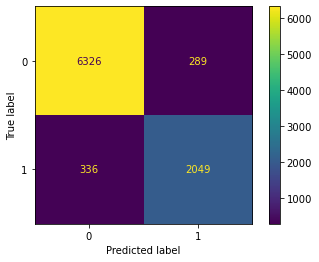

In [56]:
fig = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_test_rf_grid_pred ),
    display_labels=rfc_grid.classes_)
fig.plot();

Модель не улучшилась.

Визуализируем метрики для построенных ранее моделей.

In [57]:
from matplotlib.pyplot import figure

In [58]:
def visual_metrics(metrics):
    """_summary_

    Args:
        metrics (_type_): list
    """
    d = pd.DataFrame(data=metrics)
    print(d)
    x = np.arange(5)
    original = d.iloc[0, 1:].values
    class_weight = d.iloc[1, 1:].values
    smote = d.iloc[2, 1:].values
    under = d.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(16, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("МЕТРИКИ")
    plt.ylabel("ЗНАЧЕНИЕ")
    plt.legend(["LogisticRegression", "RFC with default params", "RFC with standard data", "RFC by GridSearchCV"], loc='right')
    plt.show()

         model to evaluate  accuracy  recall  precision  f_score    auc
0       LogisticRegression     0.882   0.747      0.796    0.747  0.839
1  RFC with default params     0.941   0.871      0.902    0.872  0.919
2   RFC with standard data     0.941   0.871      0.905    0.871  0.919
3      RFC by GridSearchCV     0.931   0.859      0.876    0.859  0.908


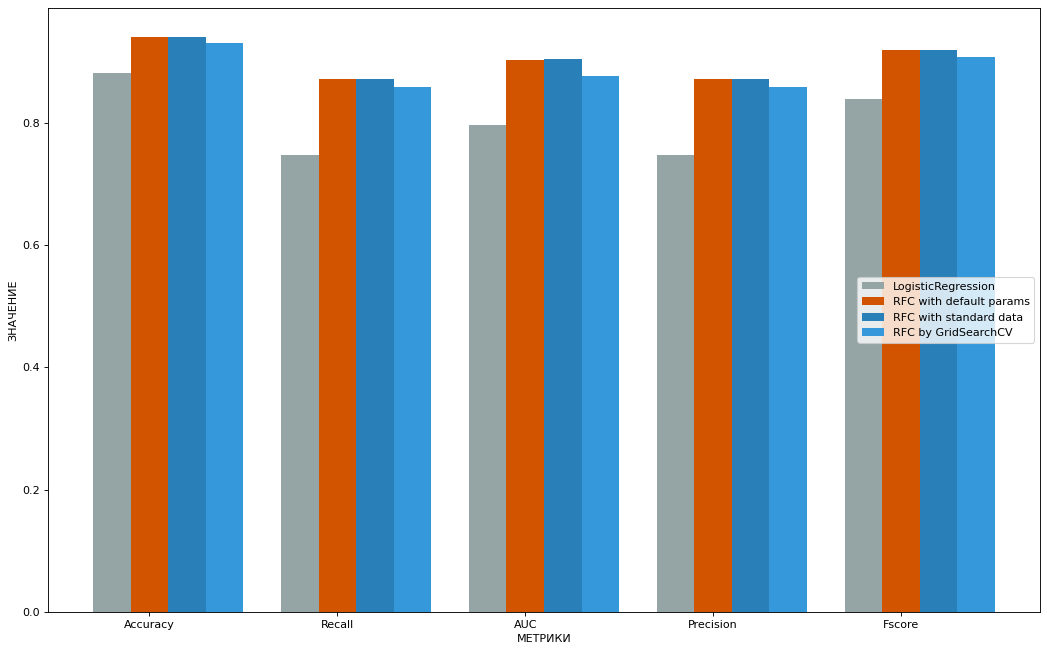

In [59]:
visual_metrics(metrics)

Также с полмощью случайного леса можно определить значимость признаков. 

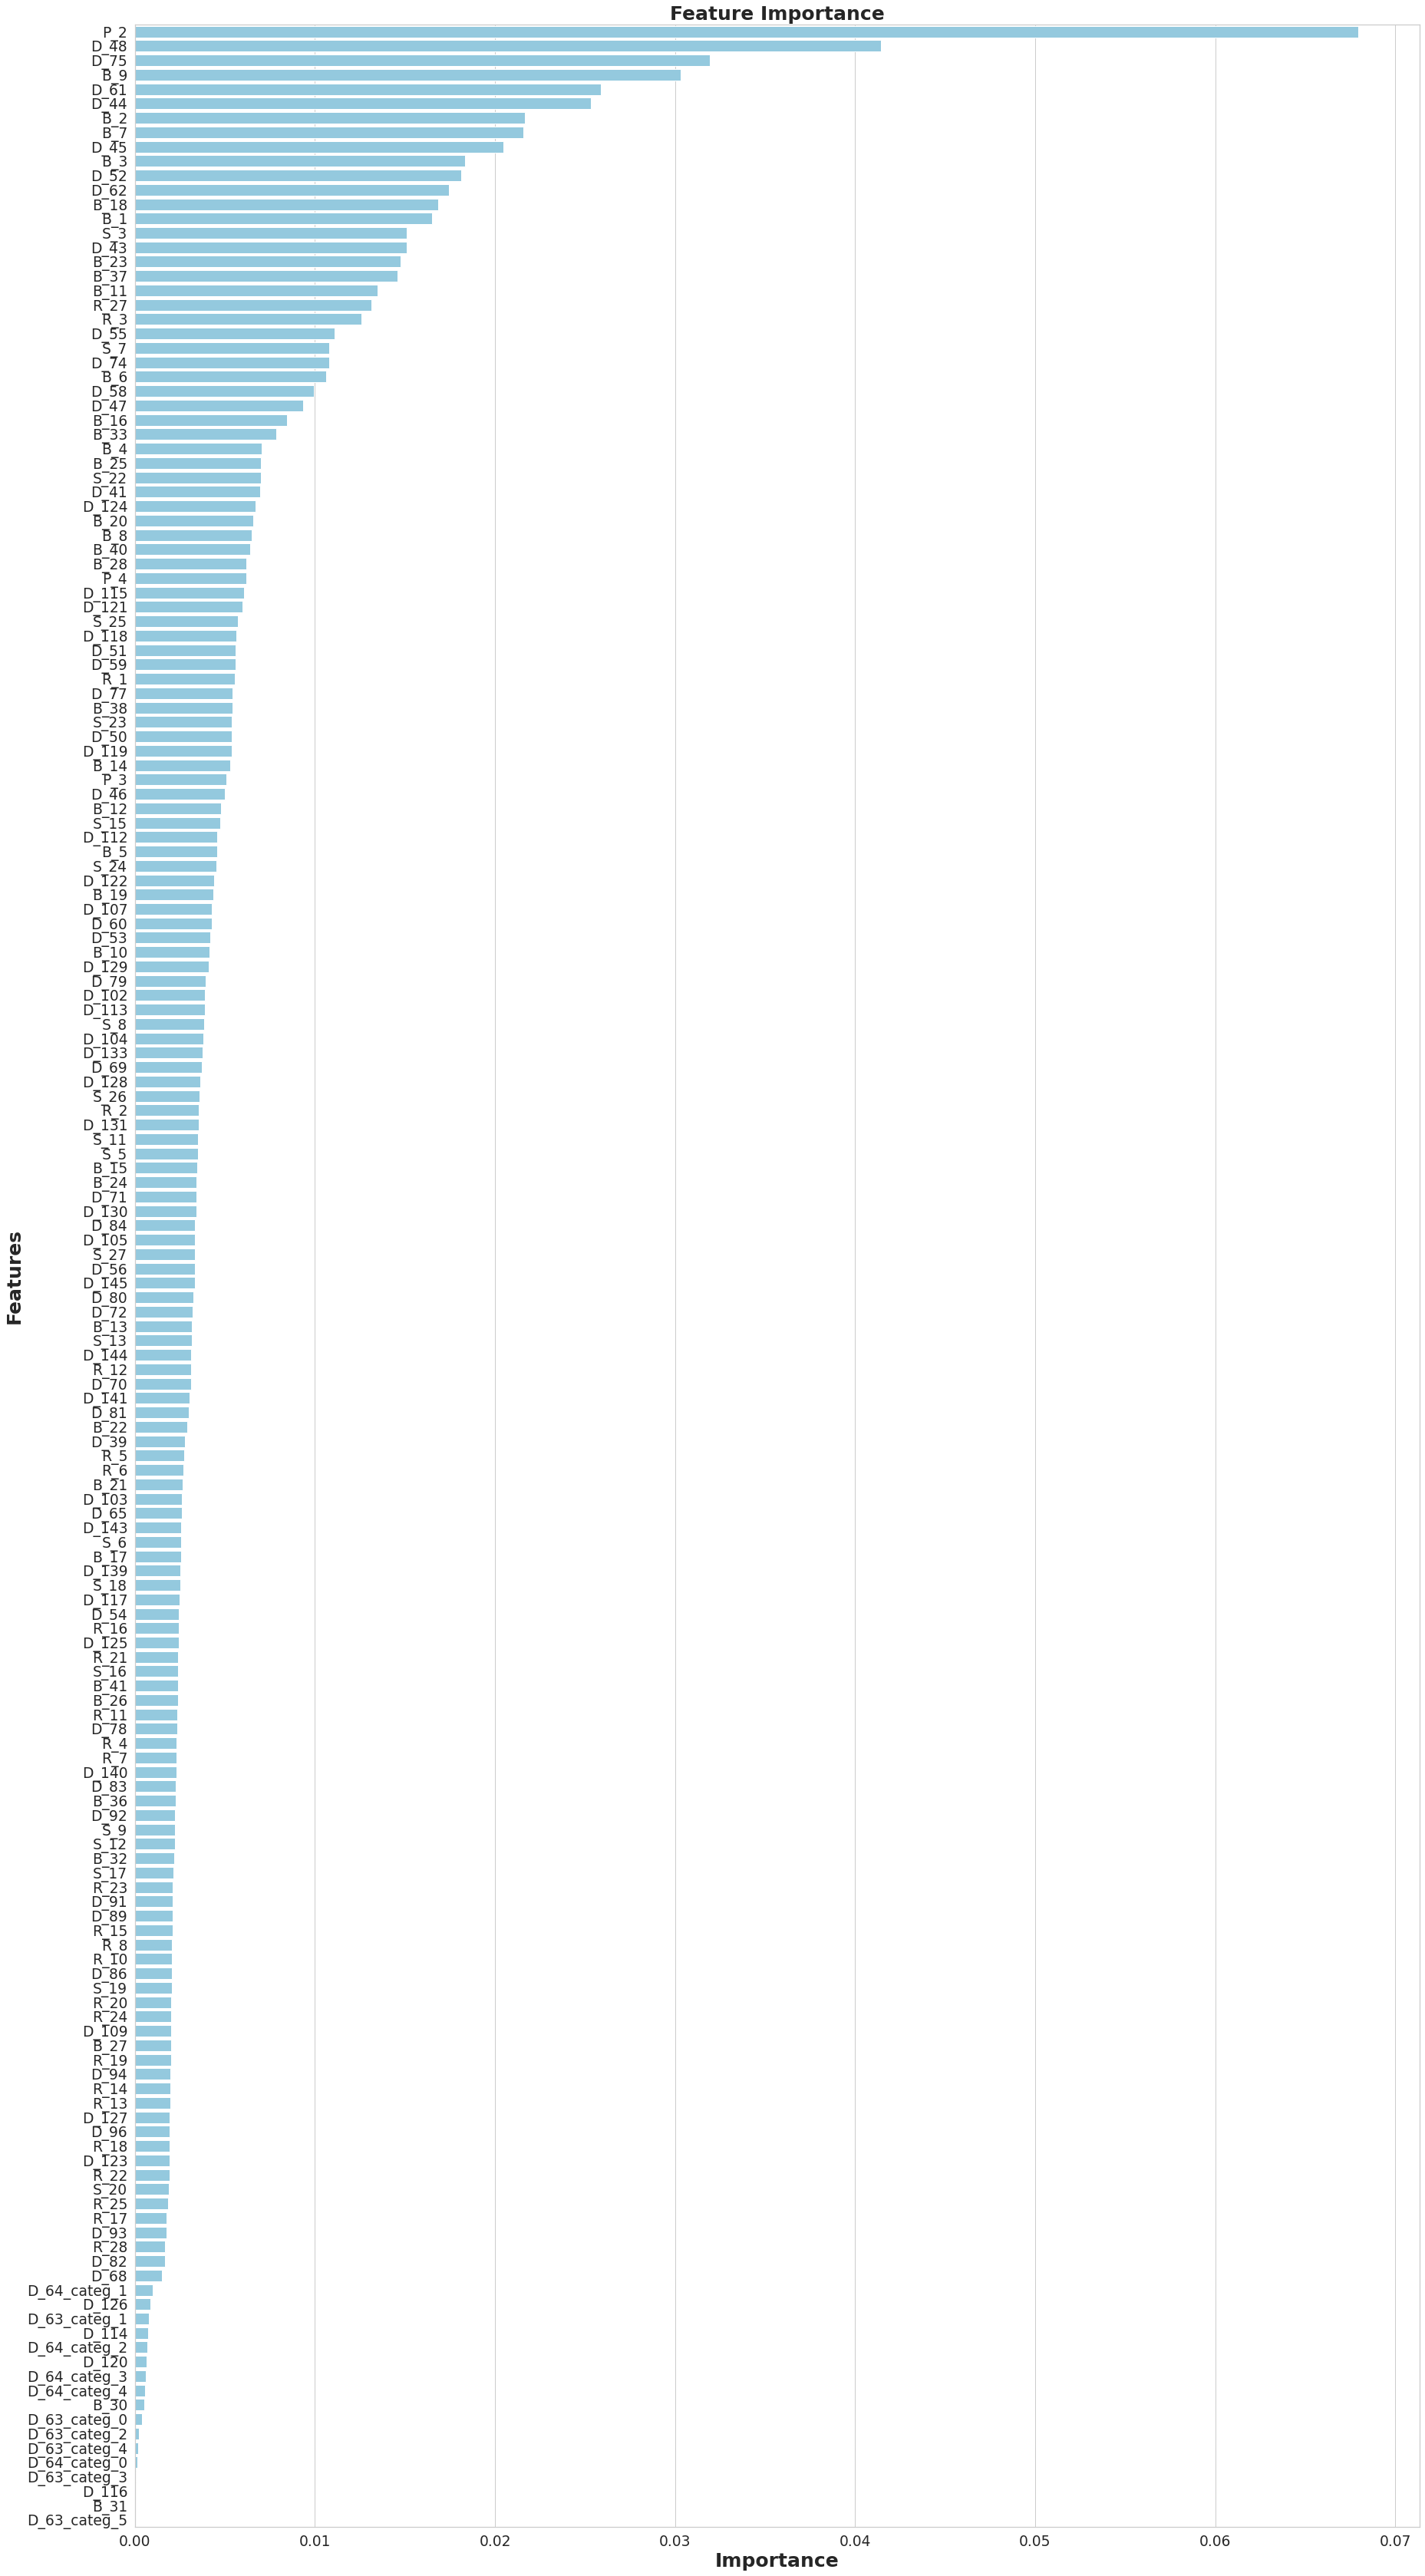

None

,Features,Gini-Importance
0,P_2,0.067950
1,D_48,0.041417
2,D_75,0.031938
3,B_9,0.030298
4,D_61,0.025888
...,...,...
169,D_64_categ_0,0.000140
170,D_63_categ_3,0.000033
171,D_116,0.000023
172,B_31,0.000011


In [60]:
feats = {}

for feature, importance in zip(X_train.columns, rf_defaults.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,60)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Были рассмотрены модели случайного леса и логистическая регрессия. Попробуем другие методы и сравним метрики.

In [61]:
metrics.pop(-1)
metrics.pop(-2)

{'model to evaluate': 'RFC with default params',
 'accuracy': 0.941,
 'recall': 0.871,
 'precision': 0.902,
 'f_score': 0.872,
 'auc': 0.919}

# 9. XGBoost

XGBoost – более регуляризованная форма градиентного бустинга. Основным преимуществом данной библиотеки является производительность и эффективная оптимизация вычислений (лучший результат с меньшей затратой ресурсов).

In [62]:
import xgboost as xgb

In [63]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [64]:
y_test_xgb_pred = xgb_model.predict(X_test)

In [65]:
metrics.append(evaluate_model(y_test, y_test_xgb_pred, "XGBClassifier"))
display(metrics)

[{'model to evaluate': 'LogisticRegression',
  'accuracy': 0.882,
  'recall': 0.747,
  'precision': 0.796,
  'f_score': 0.747,
  'auc': 0.839},
 {'model to evaluate': 'RFC with standard data',
  'accuracy': 0.941,
  'recall': 0.871,
  'precision': 0.905,
  'f_score': 0.871,
  'auc': 0.919},
 {'model to evaluate': 'XGBClassifier',
  'accuracy': 0.963,
  'recall': 0.916,
  'precision': 0.941,
  'f_score': 0.916,
  'auc': 0.948}]

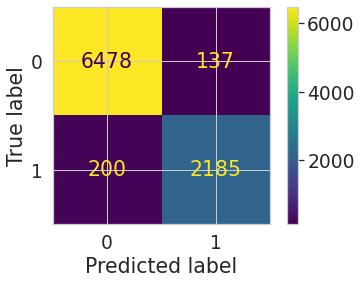

In [66]:
fig = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_test_xgb_pred),
    display_labels=xgb_model.classes_)
fig.plot();

Пока что XGBoost с параметрами по умолчанию даёт наилучшие метрики на тестовом наборе.  

Встроенные L1- и L2-регуляризации предотвращают переобучение модели, а вычисления распараллеливаются. Также данный алгоритм имеет ряд и других достоинств: кросс-валидация на каждом шаге, аппаратная оптимизация и эффективная "обрезка" деревьев.

# 10. LightGBM

Данный алгоритм известен своей более высокой скоростью обучения, хорошей точностью с параметрами по умолчанию, параллельным и GPU обучением, малым использованием памяти и возможностью обработки больших датасетов, которые не всегда помещаются в ней.

In [67]:
import lightgbm

In [68]:
lgbm = lightgbm.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_test_lgbm_pred = lgbm.predict(X_test)

In [69]:
metrics.append(evaluate_model(y_test, y_test_lgbm_pred, "LGBMClassifier"))
display(metrics)

[{'model to evaluate': 'LogisticRegression',
  'accuracy': 0.882,
  'recall': 0.747,
  'precision': 0.796,
  'f_score': 0.747,
  'auc': 0.839},
 {'model to evaluate': 'RFC with standard data',
  'accuracy': 0.941,
  'recall': 0.871,
  'precision': 0.905,
  'f_score': 0.871,
  'auc': 0.919},
 {'model to evaluate': 'XGBClassifier',
  'accuracy': 0.963,
  'recall': 0.916,
  'precision': 0.941,
  'f_score': 0.916,
  'auc': 0.948},
 {'model to evaluate': 'LGBMClassifier',
  'accuracy': 0.952,
  'recall': 0.903,
  'precision': 0.915,
  'f_score': 0.903,
  'auc': 0.936}]

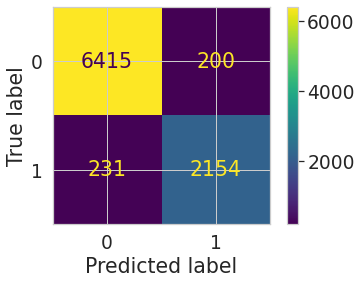

In [70]:
fig = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_test_lgbm_pred),
    display_labels=lgbm.classes_)
fig.plot();

Результат LGBMClassifier оказался чуть хуже, чем результат XGBoost.

In [71]:
def visual_metrics(metrics):
    """_summary_

    Args:
        metrics (_type_): list
    """
    d = pd.DataFrame(data=metrics)
    print(d)
    x = np.arange(5)
    original = d.iloc[0, 1:].values
    class_weight = d.iloc[1, 1:].values
    smote = d.iloc[2, 1:].values
    under = d.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(16, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("МЕТРИКИ")
    plt.ylabel("ЗНАЧЕНИЕ")
    plt.legend(["LogisticRegression", "RFC with default params", "XGBClassifier", "LGBMClassifier"], loc='right')
    plt.show()

        model to evaluate  accuracy  recall  precision  f_score    auc
0      LogisticRegression     0.882   0.747      0.796    0.747  0.839
1  RFC with standard data     0.941   0.871      0.905    0.871  0.919
2           XGBClassifier     0.963   0.916      0.941    0.916  0.948
3          LGBMClassifier     0.952   0.903      0.915    0.903  0.936


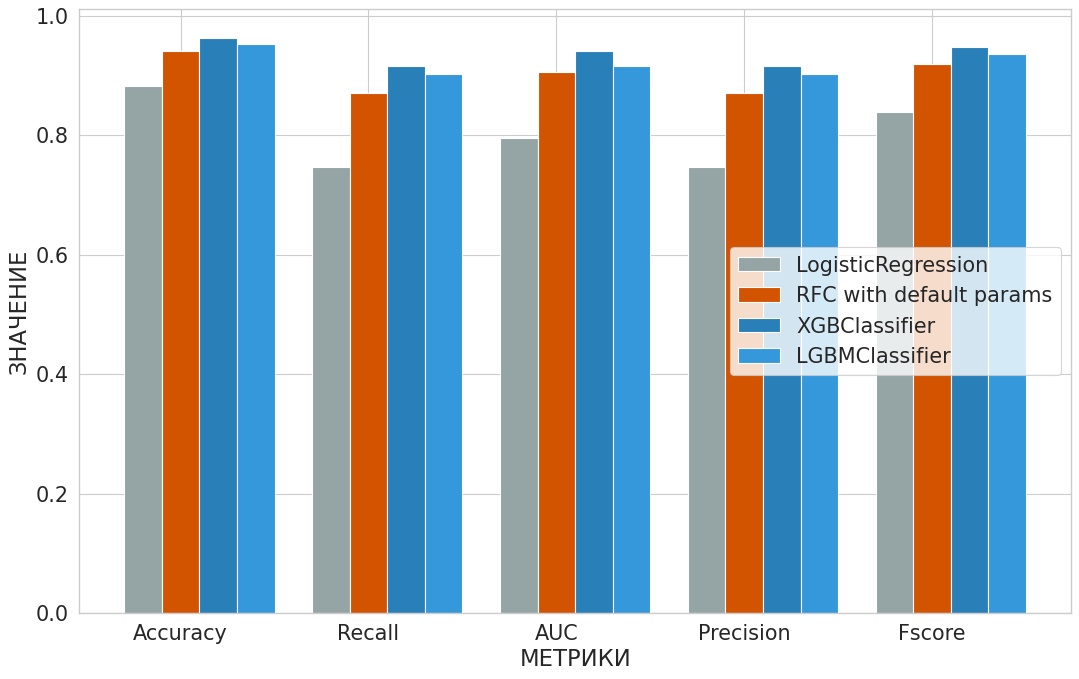

In [72]:
visual_metrics(metrics)

Лучшая модель - XGBClassifier, она показывает наилучшие метрики.

# 11. Оверсэмплинг со SMOTE

Целевая переменная весьма несбалансированная, как выяснилось ранее. 

Если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество. Самый популярный алгоритм оверсэмплинга - SMOTE (Synthetic Minority Oversampling Techniques). 

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы похожи на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировать их.

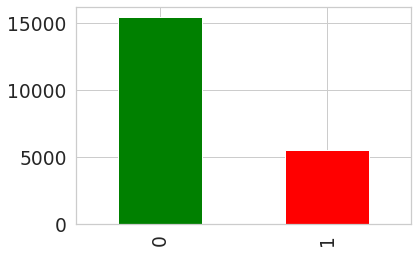

In [73]:
# До ресэплинга
y_train.value_counts().plot.bar(color=["green", "red"]);

In [74]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [75]:
sampler = SMOTE(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0a76d379d0>
Traceback (most recent call last):
  File "/home/roman/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/roman/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/roman/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/roman/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


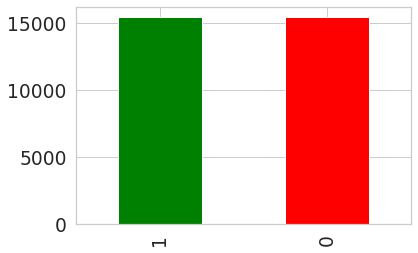

In [76]:
# После ресэмплинга
y_resampled.value_counts().plot.bar(color=["green", "red"]);

Выборки выравнены.

Обучим модель XGBClassifier на этих данных.

In [77]:
xgb_m = xgb.XGBClassifier(ratio='minority')
xgb_m.fit(X_resampled, y_resampled)
y_test_xgb_resampled_pred = xgb_m.predict(X_test)

[23:01:48] WARNING: ../src/learner.cc:767: 
Parameters: { "ratio" } are not used.



In [78]:
metrics.append(evaluate_model(y_test, y_test_xgb_resampled_pred, "XGBClassifier with SMOTE"))

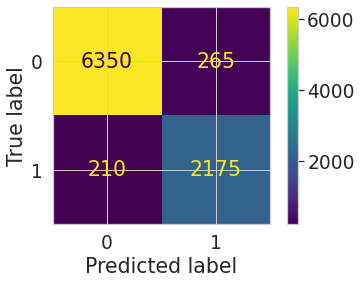

In [79]:
fig = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_test_xgb_resampled_pred),
    display_labels=xgb_m.classes_)
fig.plot();

In [80]:
# Посмотрим на метрики
metrics[::-1][0:2]

[{'model to evaluate': 'XGBClassifier with SMOTE',
  'accuracy': 0.947,
  'recall': 0.912,
  'precision': 0.891,
  'f_score': 0.912,
  'auc': 0.936},
 {'model to evaluate': 'LGBMClassifier',
  'accuracy': 0.952,
  'recall': 0.903,
  'precision': 0.915,
  'f_score': 0.903,
  'auc': 0.936}]

Ресэмплинг качество модели не улучшил. 

Лучшая модель - **XGBClassifier**.

# 12. Интерпритация модели

Посмотрим на 10 наиболее весомых признаков по метрике f_score.

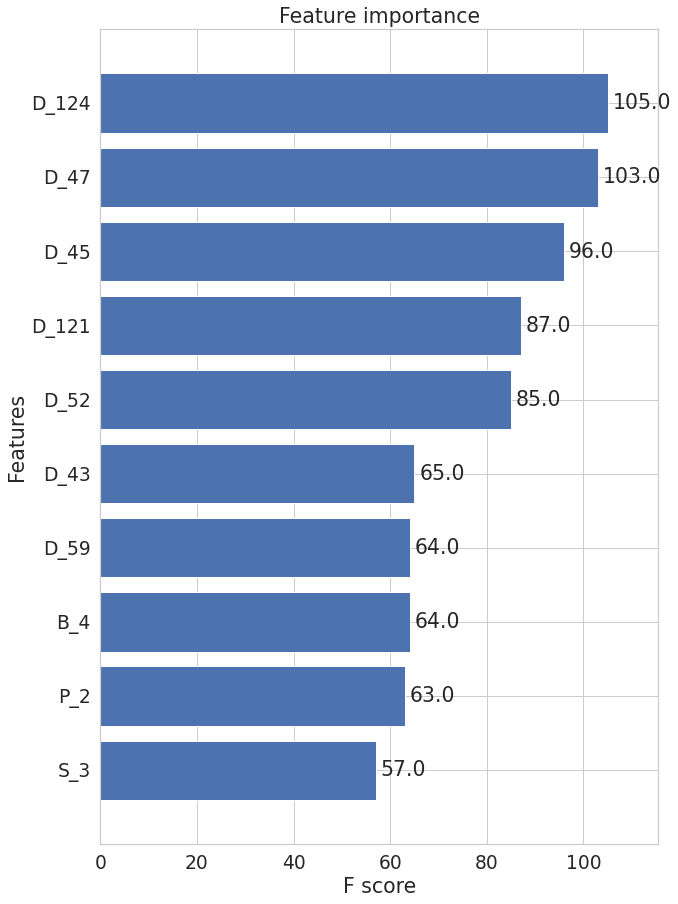

In [81]:
fig, ax = plt.subplots(figsize=(10,15))
xgb.plot_importance(xgb_model, max_num_features=10, height=0.8, ax=ax)
plt.show()

# 12.1 Partial Dependence Plots

Partial Dependence Plots (графики частичной зависимости или же PDP, PD-графики) показывают незначительное влияние одного или двух признаков на прогнозируемый результат модели машинного обучения. PDP может показать связь между целью и выбранными признаками с помощью 1D или 2D графиков.  

In [82]:
from sklearn.inspection import permutation_importance, plot_partial_dependence

/home/roman/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


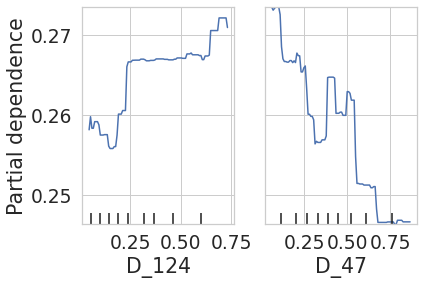

In [83]:
most_important_features = ['D_124', 'D_47'] # Два самых важных признака по графику
plot_partial_dependence(estimator=xgb_model, 
                        X=X_train, 
                        features=most_important_features,
                        random_state=42);

In [84]:
from pdpbox import pdp, get_dataset, info_plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


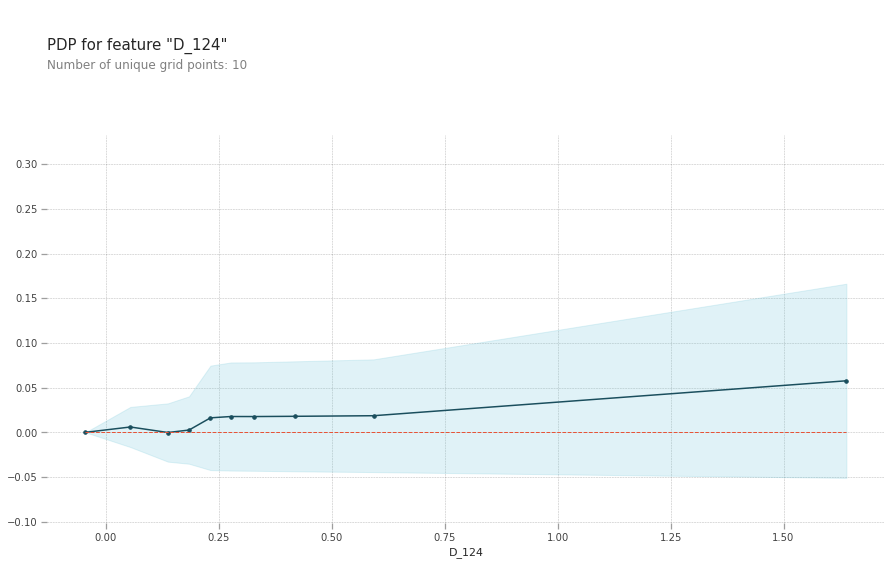

In [85]:
pdp_goals = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns, feature='D_124')

pdp.pdp_plot(pdp_goals, 'D_124')
plt.show()

Ось Y отражает изменение прогноза вследствие того, что было предсказано в исходном или в крайнем левом значении.
Синяя область обозначает интервал доверия.

# 13. Заключение и подготовка модели к деплою

Наилучшей моделью оказалась **XGBoostClassifier**. Она не требует больших вычислительных мощностей и настройки параметров. Как оказалось, она неплохо справляется с несбалансированными выборками. 

Сериализуем модель.

In [86]:
import pickle

In [87]:
with open ("xgbclassifier.pkl", "wb") as output:
    pickle.dump(xgb_model, output)

Cериализованную модель будем использовать для деплоя на веб-сервис.  
Необходимо написать веб-сервис, который позволит клиентам делать запросы к нашей модели. В ответ клиенты должны получать ответы — предсказания модели.  
У модели есть метод predict, который принимает на вход numpy-массив размерности (кол-во объектов; кол-во признаков). Всего у нас сто семьдесят четыре анонимных признака.

Давайте обернём процедуру предсказания модели в обработчик POST-запросов.